# Final Project  : Some insight about kickstarters
****
Since the crowdfunding came out, I am the huge fan of this concept. It makes people get a chance to support a innovative idea without insanely high expenditure.
And it's really inspiring to browse other people's new ideas. We sometimes find out that it is a truly great idea, but it end up failing the fundraising progress. So we grow some idea and want to discover more about what determine the successful rate of certain project.

In the project we focus on following three topcis
***
### Main topic :
####  Which are the most important features (relatively) of a project?
####  Which features have the biggest impact on the project success? 
####  How does changes in those features affact the project success?
***


In [1]:
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from pdpbox import pdp, get_dataset, info_plots
from eli5.sklearn import PermutationImportance
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import FeatureUnion
from collections import Counter
import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np 
import warnings
import eli5
warnings.filterwarnings('ignore')
init_notebook_mode(connected=True)

def syllable_count(word):
    word = word.lower()
    vowels = "aeiouy"
    count = 0
    if word[0] in vowels:
        count += 1
    for index in range(1, len(word)):
        if word[index] in vowels and word[index - 1] not in vowels:
            count += 1
    if word.endswith("e"):
        count -= 1
    if count == 0:
        count += 1
    return count

projects = pd.read_csv("./ks-projects.csv", parse_dates = ["launched", "deadline"])

print ("Total Projects: ", projects.shape[0], "\nTotal Features: ", projects.shape[1])
projects.head()

Total Projects:  378661 
Total Features:  15


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In this dataset, we can see that a number of features are about the active stage of the project. This means that a project was launched on a particular date and a partial amount is already raised. The goal of our problem statement is a little bit different, we want to focus on the stage in which the project is not launched yet and identify if it will successful or not. 

Additinaly, find the most important features (and the feature values) that influence this output. So we perform some pre-processing in this step which includes the following:
***
* Get rid of unwanted columns (active stage columns)
* Feature Engineering (driven from our hypothesis generation)
* Remove Duplicates
* Handle Missing Values 
* Encode the Categorical Features

In [2]:
projects = projects.dropna()
projects = projects[projects["currency"] == "USD"]
projects = projects[projects["state"].isin(["failed", "successful"])]
projects = projects.drop(["backers", "ID", "currency", "country", "pledged", "usd pledged", "usd_pledged_real", "usd_goal_real"], axis = 1)

In [3]:
projects["syllable_count"]   = projects["name"].apply(lambda x: syllable_count(x))
projects["launched_month"]   = projects["launched"].dt.month
projects["launched_week"]    = projects["launched"].dt.week
projects["launched_day"]     = projects["launched"].dt.weekday
projects["is_weekend"]       = projects["launched_day"].apply(lambda x: 1 if x > 4 else 0)
projects["num_words"]        = projects["name"].apply(lambda x: len(x.split()))
projects["num_chars"]        = projects["name"].apply(lambda x: len(x.replace(" ","")))
projects["duration"]         = projects["deadline"] - projects["launched"]
projects["duration"]         = projects["duration"].apply(lambda x: int(str(x).split()[0]))
projects["state"]            = projects["state"].apply(lambda x: 1 if x=="successful" else 0)

## label encoding the categorical features
projects = pd.concat([projects, pd.get_dummies(projects["main_category"])], axis = 1)
le = LabelEncoder()
for c in ["category", "main_category"]:
    projects[c] = le.fit_transform(projects[c])

1, Project Name / Description Features: 

From our hypothesis, we suggested that how the project name or description is written may affect the success of the project. So we create some features related to project name. We dont have description of the project in this dataset, so we avoid that.

* Number of Words Used
* Number of Characters Used
* Number of Syllables Used (Difficult Words)
---
2, Project Launched Date Features: 

Also, we suggested that the project first launch can affect its success. So we create some date - time related features :

* Launched Day, Month, Quarter, Week
* Total Duration of the Project
* Was project launched on weekday or weekend
* Was project launched on a holiday or regular day
---

3, Project Category Features: 

These are more likely the high level features which provides the idea about the category / sub-category of the project. Also, we add some extra information with category such as the popularity of the category calculated from the total number of projects posted in that category.

* Category Count and Sub Category Count : Generally how many projects are posted in those categories. This gives an idea if the   project belongs to a more generic category or is more of a rare project
* Category / Sub-Category Mean Goal : Generally what is the average goal set in those categories / sub-categories. This gives an idea if the project's goal is much higher or much lower than the standard mean goal of that category.
---

In [4]:
t2 = projects.groupby("main_category").agg({"goal" : "mean", "category" : "sum"})
t1 = projects.groupby("category").agg({"goal" : "mean", "main_category" : "sum"})
t2 = t2.reset_index().rename(columns={"goal" : "mean_main_category_goal", "category" : "main_category_count"})
t1 = t1.reset_index().rename(columns={"goal" : "mean_category_goal", "main_category" : "category_count"})
projects = projects.merge(t1, on = "category")
projects = projects.merge(t2, on = "main_category")

projects["diff_mean_category_goal"] = projects["mean_category_goal"] - projects["goal"]
projects["diff_mean_category_goal"] = projects["mean_main_category_goal"] - projects["goal"]

projects = projects.drop(["launched", "deadline"], axis = 1)
projects[[c for c in projects.columns if c != "name"]].head()

,category,main_category,goal,state,syllable_count,launched_month,launched_week,launched_day,is_weekend,num_words,...,Music,Photography,Publishing,Technology,Theater,mean_category_goal,category_count,mean_main_category_goal,main_category_count,diff_mean_category_goal
0,93,6,30000.0,0,11,9,35,5,1,8,...,0,0,0,0,0,57623.76924,25506,72268.329369,3678111,42268.329369
1,93,6,45000.0,0,4,1,2,5,1,3,...,0,0,0,0,0,57623.76924,25506,72268.329369,3678111,27268.329369
2,93,6,8000.0,1,5,1,4,3,0,4,...,0,0,0,0,0,57623.76924,25506,72268.329369,3678111,64268.329369
3,93,6,60000.0,1,14,1,2,5,1,10,...,0,0,0,0,0,57623.76924,25506,72268.329369,3678111,12268.329369
4,93,6,50000.0,0,8,1,3,5,1,5,...,0,0,0,0,0,57623.76924,25506,72268.329369,3678111,22268.329369


#  Modelling the Project Success
Now, with all those features prepared we are ready to train our model. We will train a single random forest regression model for this task. 

In [5]:
label = projects.state
features = [c for c in projects.columns if c not in ["state", "name"]]

## prepare training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(projects[features], label, test_size = 0.025, random_state = 2)
X_train1, y_train1 = X_train, y_train
X_test1, y_test1 = X_test, y_test

## train a random forest classifier 
model1 = RandomForestClassifier(n_estimators=50, random_state=0).fit(X_train1, y_train1)
y_pred = model1.predict(X_test1)

## Which are the most important features of a project? (Relative Feature Importance)

In [8]:
feature_importances = pd.DataFrame(model1.feature_importances_, index = X_train.columns, columns=['importance'])
feature_importances = feature_importances.sort_values('importance', ascending=False)

colors = ["gray"] * 9 + ["green"]*6
trace1 = go.Bar(y = [x.title()+"  " for x in feature_importances.index[:15][::-1]], 
                x = feature_importances.importance[:15][::-1], 
                name="feature importance (relative)",
                marker=dict(color=colors, opacity=0.4), orientation = "h")

data = [trace1]

layout = go.Layout(
    margin=dict(l=400), width = 1000,
    xaxis=dict(range=(0.0,0.15)),
    title='Relative Feature Importance (Which Features are important to make predictions ?)',
    barmode='group',
    bargap=0.25
)
fig = go.Figure(data=data, layout=layout)
fig.show()
# from IPython.display import display
# from IPython.core.display import HTML

# tag = "<div> Most Important (Relative) : "
# for feat in feature_importances.index[:10]:
#     tag += "<span><font color='green'>" +feat.title().replace("_","")+ "</font> &nbsp;|&nbsp; </span>" 
# tag += "<br>Least Important (Relative) : "
# for feat in feature_importances.index[-15:]:
#     tag += "<span><font color='red'>" +feat.title().replace("_","")+ "</font> &nbsp;|&nbsp; </span>" 
# tag += "</div>"
# display(HTML(tag))

**Inferences**
>From the graph, 
>* It is clear that the features which are important to predict the project success are: project goal, length of the project name, launched week, duration, and number of syllables present in the name. While the least important features are are mostly related to the project categories

>What does this mean for the project owner? 
>* For someone who is willing to raise funds, they should consider evaluating the ideal project goal and duration. A high or a medium-high project goal may almost lead to the case of failure. Additionally, number of characters used in the project title will also affact if the project will be succeeded or failed.

>What does this mean for the company?
>* The company can identify the projects with high importance based on their meta - features such as length of the project.

## Which features have the biggest impact on the project success? (Permutation Importance)

In the last section, we mainly identified which the features at a very high level which are relatively important to the model outcome. In this section, we will go a little deeper and understand which features has the biggest impact on the model predictions (in absolute sense). One of the ways to identify such behaviour is to use permutation importance.

**The idea of permutation importance is very straightforward. After training a model, the model outcomes are obtained. The most important features for the model are the ones if the values of those feature are randomly shuffled then they lead to biggest drops in the model outcome accuracies. Let's look at the permutation importance of features of our model.**

-----

In [9]:
from eli5.sklearn import PermutationImportance
import eli5
perm = PermutationImportance(model1, random_state=1).fit(X_test, y_test)
pi_df = eli5.explain_weights_df(perm, feature_names = X_test.columns.tolist())
pi_df["color"] = pi_df["weight"].apply(lambda x : "green" if x > 0 else "red")

data = [
    go.Bar(
        orientation = "h",
        y = pi_df.feature[::-1],
        x = pi_df.weight[::-1],
        marker = dict(
            opacity = 0.5,
            color = pi_df.color[::-1]        ),
        error_x = dict( type='data', color="#9fa3a3",
            array=list(pi_df["std"][::-1]),
            visible=True),
        name = 'expenses'
    )
]


layout = go.Layout(title="Permutation Importance", height = 800, margin=dict(l=300))

annotations = []
for i, row in pi_df.iterrows():
    dict(y=row.feature, x=row.weight, text="d",
                                  font=dict(family='Arial', size=14,
                                  color='rgba(245, 246, 249, 1)'),
                                  showarrow=False,)
layout['annotations'] = annotations
fig = go.Figure(data=data, layout = layout)
fig.show()
# iplot(fig, filename='base-bar')


**Inferences**
>This is an interesting plot, We can observe that the features shown in top and in green are the most important as if their values are randomized then the outcome performance suffers.

>We can observe that the top features are are the features which we mostly saw in the relative importance section, but using this graph we can quantify the amount of importance associated with them. And also obtain the ones which are least important, for example - launched week, if it was weekend or not etc.


With this method, we obtained the importance of a feature in a more absolute sense rathar than a relative sense. Let's assume that our feature space forms a majority of the universe. 

Now, it will be interesting to plot both permutation and relative feature importances and make some key observations.

In [10]:
imp_df = feature_importances.reset_index().rename(columns = {"index" : "feature"})
combined_df = imp_df.merge(pi_df, on="feature")

trace0 = go.Scatter(
    x = combined_df.importance,
    y = combined_df.weight,
    text = [v.title() if i < 16 else "" for i,v in enumerate(list(combined_df.feature)) ],
    mode='markers+text',
    textposition='top center',
    marker=dict(
        size = 10, color="red", opacity=0.5,
    ),
)

trace1 = go.Scatter(
    x=[0.034, 0.095],
    y=[0.008, 0.020],
    text=['Cluster of Features',
          'Highly Important Features'],
    mode='text',
)

data = [trace0]
layout = go.Layout(title = "Features : Relative Importance VS Permutation Importance", 
                   showlegend = False, yaxis=dict(title="Permutation Importance (Feature Weight)", showgrid=False),
                   xaxis=dict(title="Feature Importance (Relative)", showgrid=False))
#                       shapes = [{ 'type': 'circle', 'xref': 'x', 'yref': 'y',
#                                   'x0': 0.024, 'y0': 0.007, 'x1': 0.045, 'y1': 0.001,'opacity': 1.0,
#                                   'line': { 'color': 'rgba(50, 171, 96, 1)', 'dash': 'dot',}},
#                                { 'type': 'rect', 'x0': 0.065, 'y0': 0.019, 'x1': 0.12, 'y1': 0.0002,
#                                 'line': { 'color': 'rgba(128, 0, 128, 1)' , 'dash' : 'dot' }}])
fig = go.Figure(data = data, layout = layout)
fig.show()
# iplot(fig, filename='bubblechart-size-ref')

## Conclusion
>* From the analysis we conduct, we think the most important feature without a doubt is the fundraising goal. But the target goal most of the time varied along with the products itself. So considering the feature will mostlt influence the successful rate, we think the available duration will have biggest impact on the project success

>* Very Interesting Insights can be obtained from the above plot, There are some features which showed up higher in the relative feature importance, but when we look at their permuatation importance we see that they are not important. (Though, permutation importance results cannot be reproduced exactly because of randomness, but when I first plotted this plot I observed that launched week and month had high feature importance but lower permutation importance.)

>* From this plot, we can again observe that our hypothesis is almost true, the project goal, duration, number of characters, number of words all are the most important features that one should look at while creating a new project page.


In [11]:
def clean_name(x):   
    words = x.lower().split()
    cln = [wrd for wrd in words if not wrd[0].isdigit()]
    return " ".join(cln)
projects["cleaned_name"] = projects["name"].apply(lambda x : clean_name(x))

## add text features : top 100
vec = TfidfVectorizer(max_features=100, ngram_range=(1, 2), lowercase=True, stop_words="english", min_df=6)
X = vec.fit_transform(projects['cleaned_name'].values)

## append to original dataframe
vectors_df = pd.DataFrame(X.toarray(), columns=["_"+xx for xx in vec.get_feature_names()])
projects1_df = pd.concat([projects[features], vectors_df], axis=1)

## train the model
X_train, X_test, y_train, y_test = train_test_split(projects1_df, label, test_size = 0.25, random_state = 2)
X_train2, y_train2 = X_train[:15000], y_train[:15000]
X_test2, y_test2 = X_test[:1000], y_test[:1000]
model2 = RandomForestClassifier(random_state=1).fit(X_train2, y_train2)
y_pred = model2.predict(X_test2)

####### Interpretation 

from plotly import tools

perm = PermutationImportance(model2, random_state=1).fit(X_test2, y_test2)
pi_df = eli5.explain_weights_df(perm, feature_names = X_test2.columns.tolist(), feature_filter=lambda x: x[0] == '_')
pi_df["feature"] = pi_df["feature"].apply(lambda x : x[1:])
highs = pi_df[pi_df.weight >= 0.001]
med = pi_df[(pi_df.weight > -0.0005) & (pi_df.weight < 0.001)]
lows = pi_df[pi_df.weight <= -0.0005]

trace1 = go.Bar(
        orientation = "h",
        y = highs.feature[::-1],
        x = highs.weight[::-1],
        marker = dict(opacity = 0.4, color = "green" ), error_x = dict(type='data', color="#9fa3a3", array=list(highs["std"][::-1]), visible=True))
trace2 = go.Bar(
        orientation = "h",
        y = med.feature[:15][::-1],
        x = med.weight[:15][::-1],
        marker = dict(opacity = 0.4, color = "gray"), error_x = dict(type='data', color="#9fa3a3", array=list(med["std"][:15][::-1]), visible=True))
trace3 = go.Bar(
        orientation = "h",
        y = lows.feature,
        x = lows.weight,
        marker = dict(opacity = 0.4, color = "red"), error_x = dict(type='data', color="#9fa3a3", array=list(lows["std"][::-1]), visible=True))

ttls = ["Positive Impact","", "Moderate + or - Impact" ,"", "Negative Impact"]
fig = tools.make_subplots(rows=1, cols=5, print_grid=False, subplot_titles = ttls)
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 3)
fig.append_trace(trace3, 1, 5)

fig['layout'].update(showlegend=False, title='Impact of Words Used in Project Name - Permutation Importance')
fig.show()
# iplot(fig, filename='simple-subplot-with-annotations')

## How does changes in features lead to changes in model outcome? (**Partial Dependencies**)
----
In this section, we will look at what are the specific values or ranges of features which leads to project success or failure. Specifically, we will observe that how making changes such as increasing or decreasing the values affect the model outcomes. These effects can be obtained by plotting the partial dependency plots of different features.

----
**Project Name - Features**


findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans.


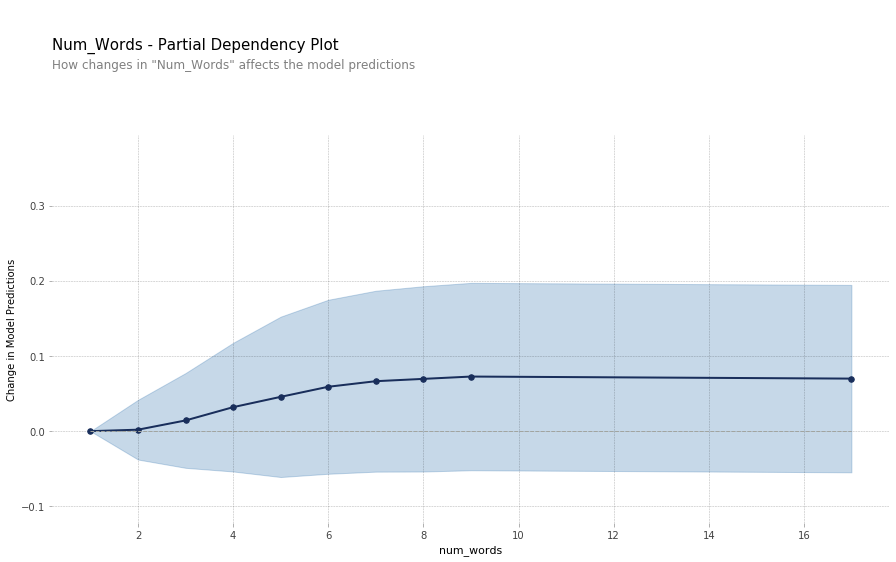

In [10]:
def _plot_pdp(feature, pdp_color, fill_color):
    plot_params = {
        'title': feature.title() + ' - Partial Dependency Plot',
        'title_fontsize': 15,
        'subtitle': 'How changes in "%s" affects the model predictions' % feature.title(),
        'subtitle_fontsize': 12,
        'font_family': 'Calibri',
        'xticks_rotation': 0,
        'line_cmap': 'cool',
        'zero_color': '#a2a5a0',
        'zero_linewidth': 1.0,
        'pdp_linewidth': 2.0,
        'fill_alpha': 0.25,
        'markersize': 5.5,
        'pdp_hl_color': 'green',
        'pdp_color': pdp_color,
        'fill_color': fill_color,

    }
    pdp_goals = pdp.pdp_isolate(model=model1, dataset=X_test1, model_features=X_test1.columns, feature=feature)
    pdp.pdp_plot(pdp_goals, feature, plot_params = plot_params)
    plt.ylabel("Change in Model Predictions");
    plt.show();
    
cols_of_interest = ['num_words', 'num_chars', 'syllable_count',
                    'duration', 'launched_month', 'launched_day',
                    'category_count', 'main_category_count']

_plot_pdp(cols_of_interest[0], "#192e5b", "#1d65a6")

> We observe that the projects having fewer number of words (<= 3) in the name does not show any improvement in model success. 
* However, if one start increasing the number of words in the project name, the corresponding model improvement also increases linearly. For all the projects having more than 10 words in the name, the model becomes saturate and shows similar predictions. Hence, the ideal word limit is somewhere around 7 - 10.

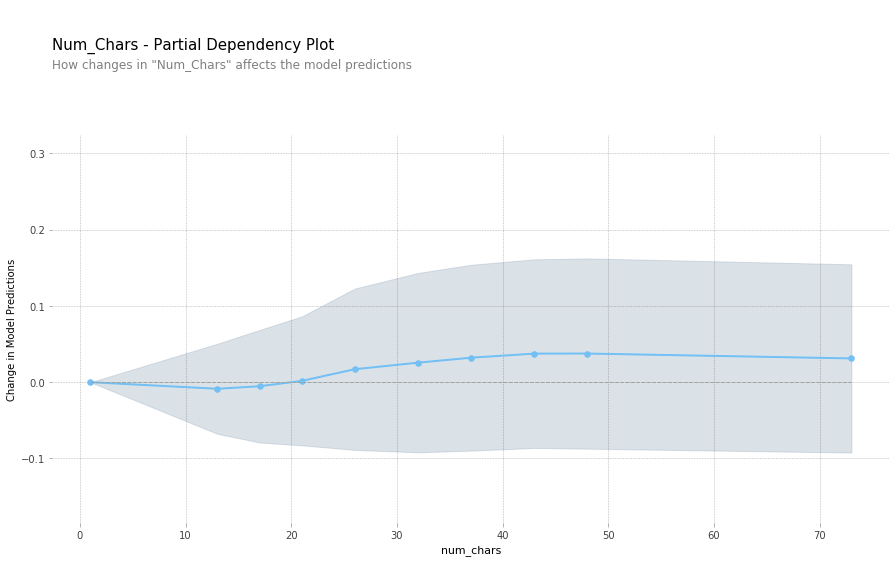

In [11]:
_plot_pdp(cols_of_interest[1], "#73c0f4", "#728ca3")


> From the 2nd plot, we observe that if the total number of characters are less than 20, then model performance decreases than a normal value. Increasing the characters in the name linearly also increases the model performances.

----
**Project Launched Day and Duration**


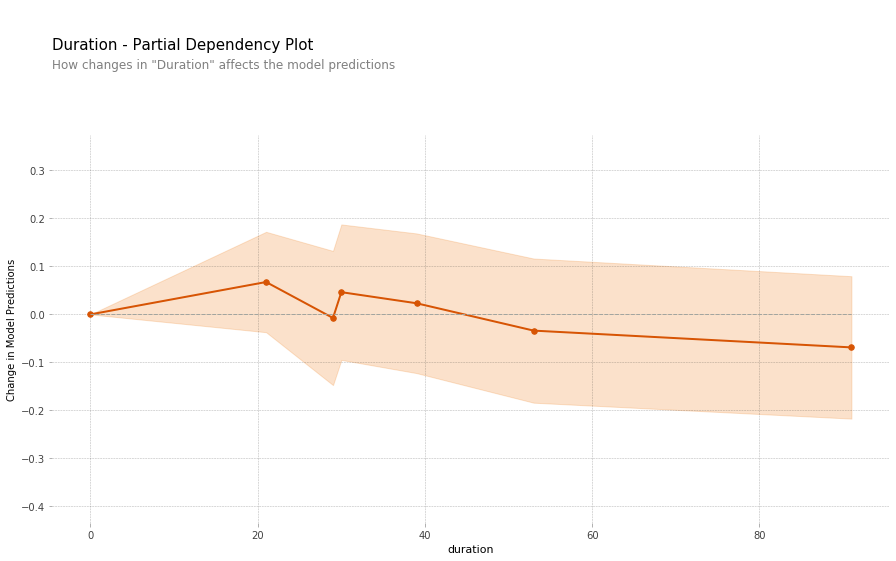

In [12]:
_plot_pdp(cols_of_interest[3], "#d75404", "#f08b33")


> For shorter project duration (less than 20 days), the chances that project will be successful are higher. 
* However if the duration of a project is increased to say 60-90 days, it is less likely to acheive its goal.

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


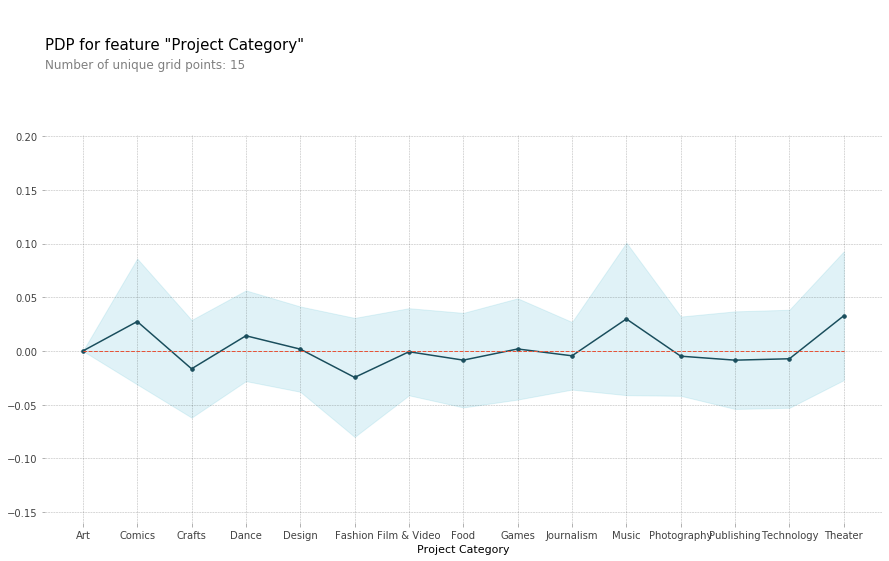

In [13]:
pdp_category = pdp.pdp_isolate(model=model1, dataset=X_test1, model_features=X_test1.columns,
                             feature=['Art', 'Comics', 'Crafts', 'Dance', 'Design', 'Fashion', 'Film & Video', 
                                      'Food', 'Games', 'Journalism', 'Music', 'Photography', 'Publishing', 'Technology', 'Theater'])
fig, axes = pdp.pdp_plot(pdp_isolate_out = pdp_category, feature_name='Project Category', 
                         center=True, plot_lines=False, frac_to_plot=100, plot_pts_dist=False)

>From the partial dependency plot for project category,
* we observe that the accuracy of model predicting the project success increases if it belongs to "Music", "Comics", "Theater", or "Dance" categories. 
* It decreases if it belongs to "Crafts", "Fashion Film & Video". The same insights can be backed from the actual predictions plot.

### We also did the text mining, and find out the most frequently used key words in the project name.

(-0.5, 999.5, 799.5, -0.5)

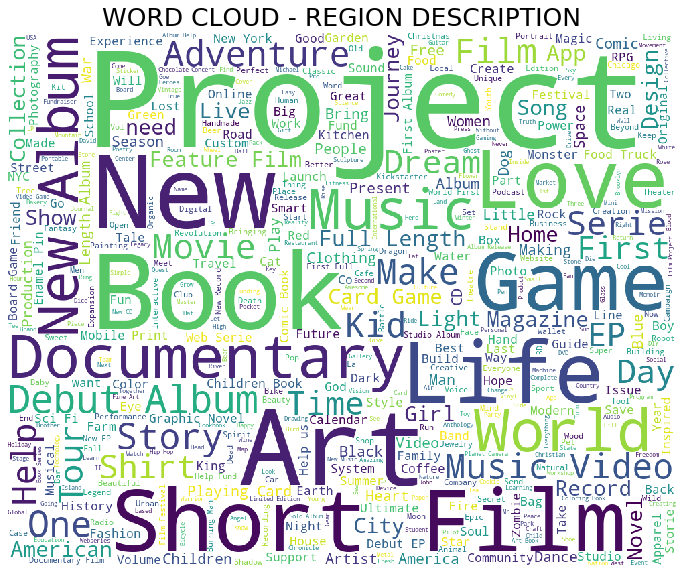

In [14]:
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)
wordcloud = WordCloud(
    background_color='white',
    stopwords=stopwords,
    max_words=500,
    max_font_size=200,
    width=1000, height=800,
    random_state=42,
).generate(" ".join(projects["name"].astype(str)))

print(wordcloud)

fig = plt.figure(figsize = (12,14))
plt.imshow(wordcloud)
plt.title("WORD CLOUD - REGION DESCRIPTION",fontsize=25)
plt.axis('off')